# Hodgkin-HuxleyモデルのFI curveをplotする
ライブラリをimportします

In [28]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

次にモデルを定義します。

In [4]:
class HodgkinHuxleyModel:
    def __init__(self, dt=1e-3, solver="RK4"):
        self.C_m  =   1.0 # 膜容量 (uF/cm^2)
        self.g_Na = 120.0 # Na+の最大コンダクタンス (mS/cm^2)
        self.g_K  =  36.0 # K+の最大コンダクタンス (mS/cm^2)
        self.g_L  =   0.3 # 漏れイオンの最大コンダクタンス (mS/cm^2)
        self.E_Na =  50.0 # Na+の平衡電位 (mV)
        self.E_K  = -77.0 # K+の平衡電位 (mV)
        self.E_L  = -54.387 #漏れイオンの平衡電位 (mV)
        
        self.solver = solver
        self.dt = dt
        
        # V, m, h, n
        self.states = np.array([-65, 0.05, 0.6, 0.32])
        self.I_inj = None
    
    def Solvers(self, func, x, dt):
        # 4th order Runge-Kutta法
        if self.solver == "RK4":
            k1 = dt*func(x)
            k2 = dt*func(x + 0.5*k1)
            k3 = dt*func(x + 0.5*k2)
            k4 = dt*func(x + k3)
            return x + (k1 + 2*k2 + 2*k3 + k4) / 6
        
        # 陽的Euler法
        elif self.solver == "Euler": 
            return x + dt*func(x)
        else:
            return None
        
    # イオンチャネルのゲートについての6つの関数
    def alpha_m(self, V):
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        return 0.125*np.exp(-(V+65) / 80.0)

    # Na+電流 (uA/cm^2)
    def I_Na(self, V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    # K+電流 (uA/cm^2)
    def I_K(self, V, n):
        return self.g_K  * n**4 * (V - self.E_K)

    # 漏れ電流 (uA/cm^2)
    def I_L(self, V):
        return self.g_L * (V - self.E_L)
        
    # 微分方程式
    def dALLdt(self, states):
        V, m, h, n = states
        
        dVdt = (self.I_inj - self.I_Na(V, m, h) \
                - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return np.array([dVdt, dmdt, dhdt, dndt])
    
    def __call__(self, I):
        self.I_inj = I
        states = self.Solvers(self.dALLdt, self.states, self.dt)
        self.states = states
        return states

シミュレーションのための定数と入力電流の大きさを定義します。入力電流は0～30uA/cm$^2$の間から50回サンプリングします。

In [8]:
dt = 0.01; T = 500 # (ms)
nt = round(T/dt) # ステップ数

N = 50
I_inj = np.sort(30*np.random.rand(N)) # 刺激電流 (uA/cm^2)
firing_rate = np.zeros(N) # 発火率の記録用配列

入力電流を確認しておきます。

In [9]:
I_inj

array([ 0.25898393,  0.58540839,  0.63372405,  0.922206  ,  0.92693746,
        4.11140144,  4.37448833,  5.85445395,  6.29928263,  6.33229761,
        6.37900989,  7.65039074,  8.6641491 ,  8.98230984, 10.46369835,
       10.92631924, 10.99678457, 11.3542475 , 11.71461959, 11.78827167,
       12.23116329, 12.57366304, 14.37297872, 15.08918803, 15.34638366,
       15.52960925, 15.63810896, 16.2993015 , 16.5329323 , 17.38720276,
       18.25247975, 18.9745069 , 19.76695294, 20.10668766, 20.56184969,
       21.16658323, 21.54429203, 21.74503282, 21.97272258, 22.21142224,
       22.34060333, 22.82560621, 22.88899313, 24.24171949, 25.13223366,
       27.01472273, 27.26022086, 27.95931478, 28.16317976, 29.78231273])

シミュレーションを実行します。

In [12]:
for j in tqdm_notebook(range(N)):
    HH_neuron = HodgkinHuxleyModel(dt=dt, solver="Euler")
    V_arr = np.zeros((nt, 4)) # 記録用配列
    
    # シミュレーション
    for i in range(nt):
        X = HH_neuron(I_inj[j])
        V_arr[i] = X[0]
           
    spike = np.bitwise_and(V_arr[:-1]<0, V_arr[1:]>0)
    rate = np.sum(spike) / T*1e3
    
    firing_rate[j] = rate

C:\Users\user\miniconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


結果をplotします。

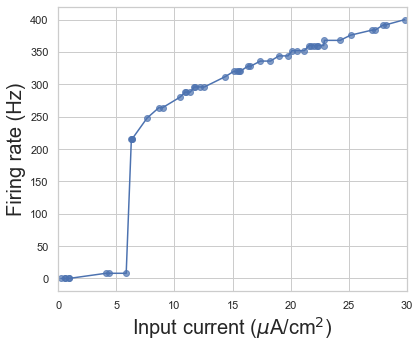

In [34]:
plt.figure(figsize=(6, 5))
plt.plot(I_inj, firing_rate)
plt.scatter(I_inj, firing_rate, alpha=0.7)
plt.xlabel('Input current ($\mu$A/cm$^2$)', size=20)
plt.ylabel('Firing rate (Hz)', size=20) 
plt.xlim(0, 30)
plt.tight_layout()
plt.savefig("HH_FIcurve.png", dpi=300)
plt.show()